<a href="https://colab.research.google.com/github/hl533/CS634FinalProject/blob/master/Copy_of_CS634Final_NYCTaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NYC Taxi Trip Duration Challenge

The goal of this challenge is to predict the duration of NYC Taxi rides in NYC based on data from the Kaggle Challenge at https://www.kaggle.com/c/nyc-taxi-trip-duration. The data comes in the form of 1.5 million observations (each one an individual taxi trip with multiple features like trip coordinates, pickup time, and date) and 630 thousand test observations.

We will first explore original data, examine potential outliers and engineer data . In the data exploration, we will focus on trip_duration, and create graph to see relationships between trip_duration vs vendor_id, passenage_count vs trip_duration, pickups vs dropoffs. Then, we will combine our Taxi trip data with weather data, as we assume that weather is a major impact to increase or decrease number of trip in the city. Finally, we will make a brief excursion into viewing this challenge as a classification problem and finish this notebook by providing a basic prediction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# libraries / imports
import numpy as np #for linear algebra
import os # for writing to directory
import pandas as pd # for data/csv file access and processing
import matplotlib as mpl #plotting and visualization of data
import matplotlib.pyplot as plt # plotting and visualization of data
import seaborn as sns # further visualization
import zipfile # for unzipping zip files from kaggle
from datetime import datetime # for processing time and date data
from sklearn.preprocessing import LabelEncoder # transforming strings into numerical classes
from geopy.geocoders import Nominatim # to properly process geo-coordinate data
from sklearn.model_selection import train_test_split, cross_val_score
# this randomly folds into training and test sets, and cross_val_score evaluates the score of the test fold
from sklearn.ensemble import RandomForestRegressor
# this combines multiple decision trees when it comes time to analyze the data
from sklearn.metrics import mean_squared_log_error, mean_squared_error
# This will give us the Root Mean Squared Log Error that this competition is using
# to calculate score
import lightgbm as lgb # a lightweight machine learning algorithm that uses tree based learning

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures within this notebook
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams['figure.figsize'] = [15, 10]

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import warnings # Ignore useless warnings
warnings.filterwarnings('ignore')
print('Libraries successfully imported and configuration of plots set.')
print("Files and/or Directories in Google Drive:")
print(os.listdir())

Libraries successfully imported and configuration of plots set.
Files and/or Directories in Google Drive:
['.config', 'drive', 'sample_data']


In [3]:
os.environ['KAGGLE_USERNAME'] = "hl533njit"
os.environ['KAGGLE_KEY'] = "02a6cedbb0e0800d3413432e287f2257"
!kaggle competitions download -c nyc-taxi-trip-duration
# above is the original dataset. going to try the below dataset that includes simulated routes and distances
# !kaggle datasets download -d oscarleo/new-york-city-taxi-with-osrm
!kaggle datasets download -d cabaki/knycmetars2016
# api copied from kaggle
print('Kaggle Datasets Successfully Downloaded')

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 83.6MB/s]
 65% 41.0M/62.9M [00:02<00:02, 10.8MB/s]
100% 62.9M/62.9M [00:02<00:00, 26.7MB/s]
 25% 5.00M/20.3M [00:00<00:00, 23.8MB/s]
100% 20.3M/20.3M [00:00<00:00, 67.7MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 101MB/s]
Kaggle Datasets Successfully Downloaded


In [4]:
# extract Training zipfile
import zipfile
zip = zipfile.ZipFile('train.zip')
zip.extractall()
print('Training Dataset Successfully UnZipped to train.csv')

Training Dataset Successfully UnZipped to train.csv


In [5]:
# extract Test zipfile
import zipfile
zip = zipfile.ZipFile('test.zip')
zip.extractall()
print('Test Dataset Successfully UnZipped to test.csv')

Test Dataset Successfully UnZipped to test.csv


In [6]:
# extract sample_submission.zip
zip = zipfile.ZipFile('sample_submission.zip')
zip.extractall()
print('sample_submission successfully unzipped')

sample_submission successfully unzipped


In [0]:
# extract NYC Taxi with OSRM Dataset
# zip = zipfile.ZipFile('new-york-city-taxi-with-osrm.zip')
# zip.extractall()
# print('Taxi Trip files successfully unzipped')

In [8]:
# extract KNYC_Metars / Weather file
zip = zipfile.ZipFile('knycmetars2016.zip')
zip.extractall()
print('Weather data successfully unzipped')

Weather data successfully unzipped


In [9]:
print(os.listdir())

['.config', 'sample_submission.csv', 'test.csv', 'test.zip', 'KNYC_Metars.csv', 'sample_submission.zip', 'train.csv', 'drive', 'knycmetars2016.zip', 'train.zip', 'sample_data']


In [10]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print('Test and Training Data CSVs successfully converted to Panda Dataframes')

Test and Training Data CSVs successfully converted to Panda Dataframes


In [11]:
print(f"Shape of training set{df_train.shape}")
print(f"Shape of test set{df_test.shape}")

Shape of training set(1458644, 11)
Shape of test set(625134, 9)


In [12]:
#read first five rows of training dataset
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Some information about the data we're provided:**

Column# 1: id - a unique identifier for each trip.

Column# 2: vendor_id - only has 1 & 2, so it might indicate two taxi companies.

Column# 3: pickup_datetime - date and time when the meter was engaged.

Column# 4: dropoff_datetime - date and time when the meter was disengaged.

Column# 5: passenger_count - the number of passengers in the vehicle (driver entered value).

Column# 6: pickup_longitude - the longitude where the meter was engaged.

Column# 7: pickup_latitude - the latitude where the meter was engaged.


Column# 8: dropoff_longitude - the longitude where the meter was disengaged.

Column# 9: dropoff_latitude - the latitude where the meter was disengaged.

Column# 10: store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

Column# 11: trip_duration - duration of the trip in seconds.

In [13]:
#return information about the dataframe including the data types of each column and memory usage
# of the entire data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [14]:
#read first five rows of test dataset
import pandas as pd
df_test = pd.read_csv('test.csv')
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [15]:
# return information about the dataframe including the data types of each column and memory usage
# of the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [16]:
# Descriptive statistics that summarize the central tendency, dispersion and shape of the 
# training dataset’s distribution, excluding NaN values
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [17]:
# Getting more information about the data features that have discrete values/categories
print(f"vendor_id has {len(df_train.vendor_id.unique())} unique values: {sorted(list(df_train.vendor_id.unique()))}")
print(f"store_and_fwd_flag has {len(df_train.store_and_fwd_flag.unique())} unique values: {list(df_train.store_and_fwd_flag.unique())}")
print(f"passenger_count has {len(df_train.passenger_count.unique())} unique values: {sorted(list(df_train.passenger_count.unique()))}")

vendor_id has 2 unique values: [1, 2]
store_and_fwd_flag has 2 unique values: ['N', 'Y']
passenger_count has 10 unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Exploring the Data:
In this second section, we're going to start visualizing the data in various ways through Matplotlib.pyplot

### trip_duration

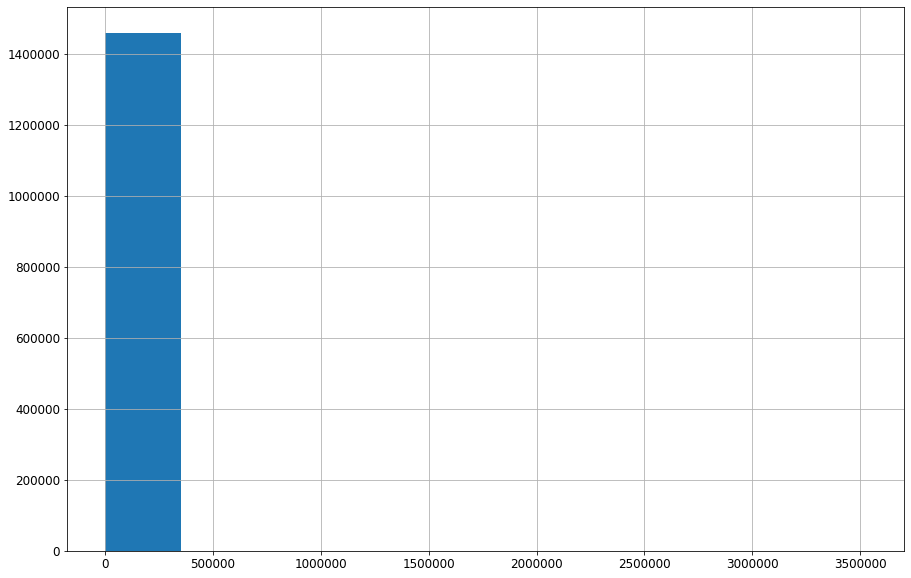

In [18]:
# Visualizing the distribution of trip_duration
df_train.trip_duration.hist();

What we learned: It looks like there may be some outliers in trip_duration. The next step is to find them.

In [19]:
len(df_train.trip_duration[df_train.trip_duration>5400].values)


3097

What we learned: There are 3097 trips that exceed 5400 seconds (1.5 hours). Seems like a good cutoff point.

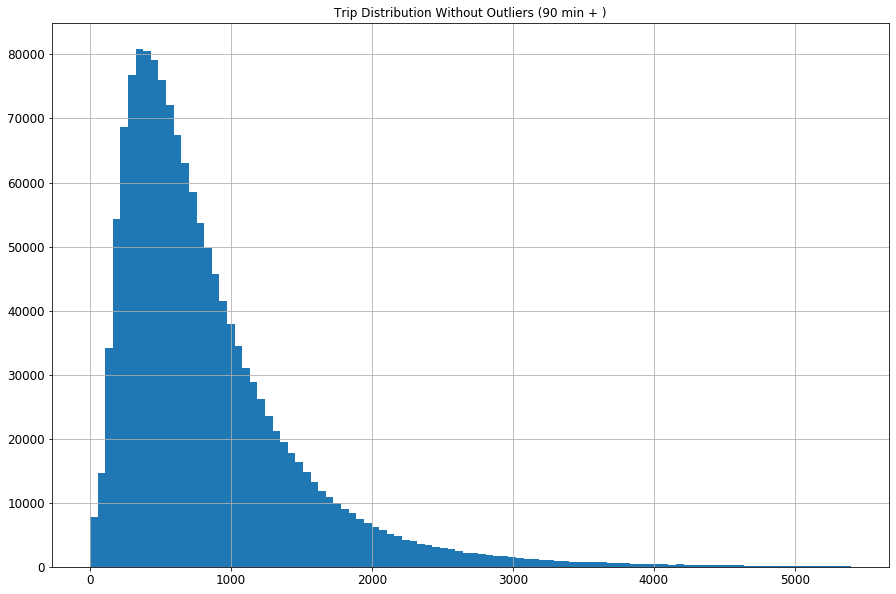

In [20]:
df_train.loc[df_train.trip_duration<5400,"trip_duration"].hist(bins=100)
plt.title("Trip Distribution Without Outliers (90 min + )");


What we learned: Looks like a log-normal distribution

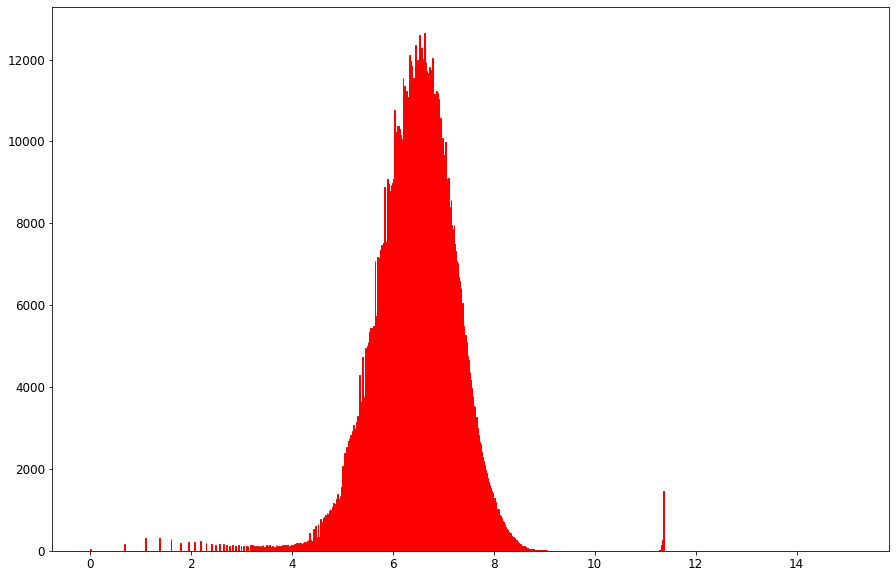

In [21]:
plt.hist(np.log(df_train.trip_duration), bins=1000, edgecolor='red');

What we learned: The log-transformation of trip_duration ***is*** almost a normal distribution

In [22]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'])
print("Created a new feature in the training dataframe: log_trip_duration")

Created a new feature in the training dataframe: log_trip_duration


### Trip Duration & Vendor Types

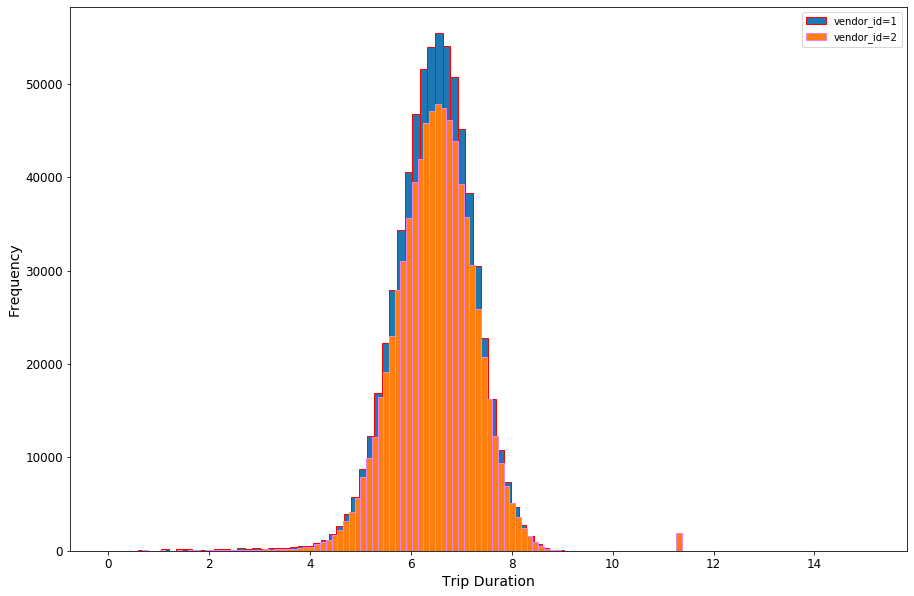

In [23]:
plt.hist(df_train.loc[df_train.vendor_id==1, 'log_trip_duration'], bins=100, edgecolor='red')
plt.hist(df_train.loc[df_train.vendor_id==2, 'log_trip_duration'], bins=100, edgecolor='violet')
plt.xlabel("Trip Duration")
plt.ylabel("Frequency")
plt.legend(['vendor_id=1', 'vendor_id=2']);

What we learned:

1.   Vendor 1 has done more trips than vendor 2
2.   Distribution of trip duration is very similar
3.   The outliers seem to be almost all in vendor 2. This needs further analysis. 

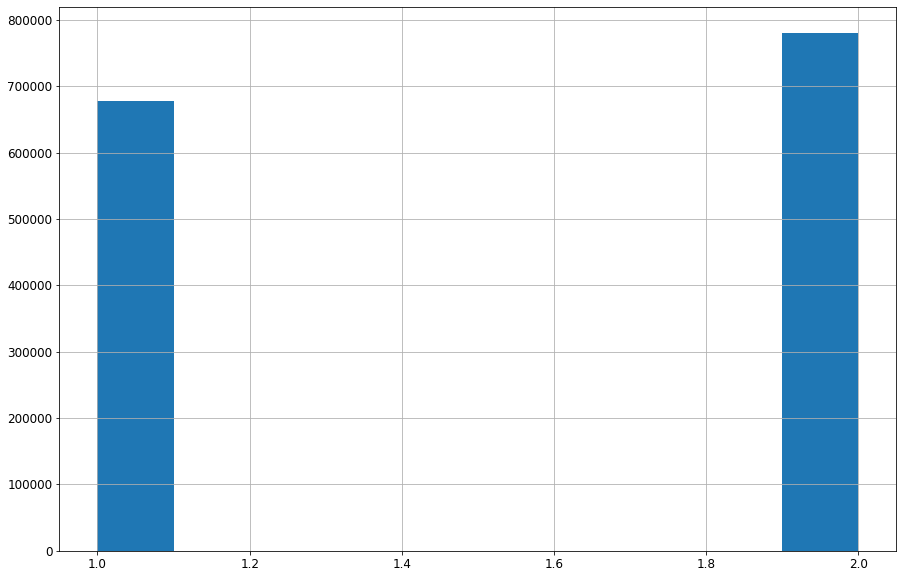

In [24]:
df_train.vendor_id.hist();

In [25]:
df_train.drop(df_train[(df_train.log_trip_duration < 4) | (df_train.log_trip_duration > 9)].index, inplace=True)
print("Rows with log_trip_durations less than 4 or greater than 9 dropped as outliers")

Rows with log_trip_durations less than 4 or greater than 9 dropped as outliers


### Passenger Count vs Trip Duration

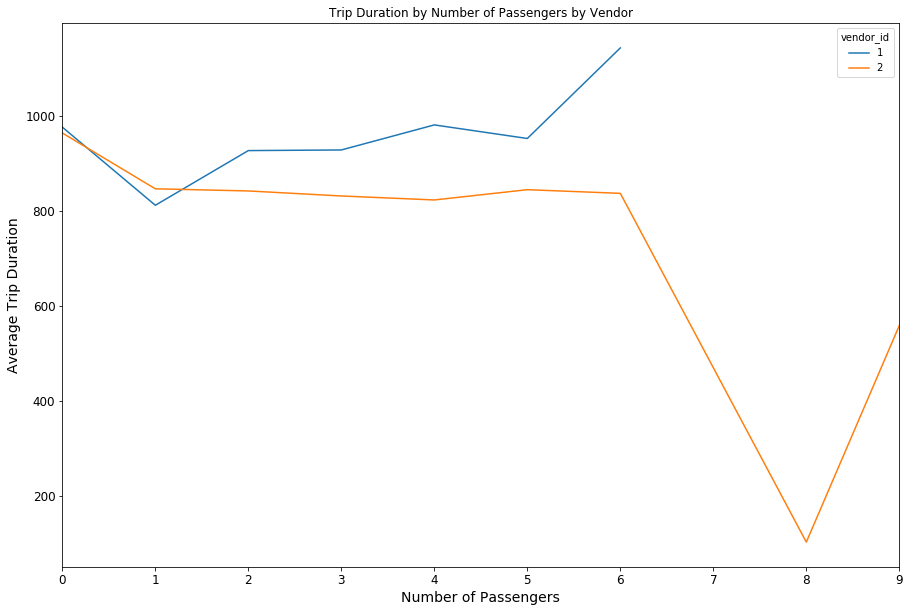

In [26]:
df_train.groupby(['vendor_id','passenger_count'])['trip_duration'].agg(
    'mean').unstack(level=0).plot()
plt.ylabel("Average Trip Duration")
plt.xlabel("Number of Passengers")
plt.title("Trip Duration by Number of Passengers by Vendor");

What we learned:
1.   Trip duration vs Passenger # is fairly stable between vendors when carrying 1-6 passengers
2.   Trip duration for 0 passengers is approximately 8 minutes for vendor 1 and 50 minutes for Vendor 2. (*Possibly deadheading to/from one of the area airports or passenger data was not recorded?*)
3.   Vendor 1 had a max of 6 passengers. Vendor 2 could also do 7-9 passengers, but these were generally short trips. (*Maybe some kind of short shuttle service?*)

### Coordinates of Pickups and Dropoffs

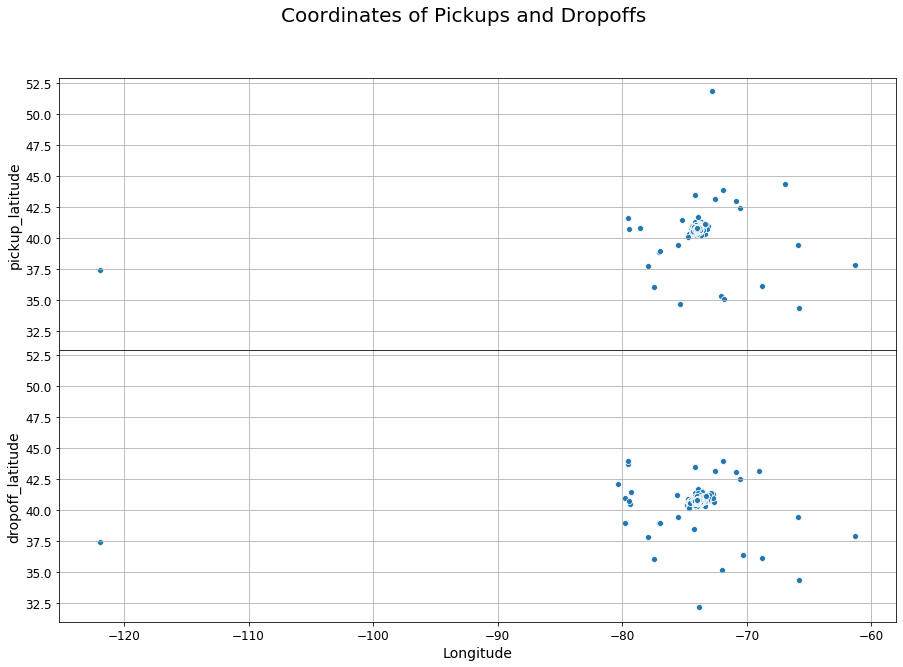

In [27]:
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
fig.suptitle('Coordinates of Pickups and Dropoffs',fontsize=20)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude',data=df_train,ax=ax[0]);
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude',data=df_train,ax=ax[1]);
for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlabel('Longitude')
    ax.grid()

In [0]:
# pu=plt.scatter(x='pickup_longitude', y='pickup_latitude',data=df_train, s=4)
# do=plt.scatter(x='dropoff_longitude', y='dropoff_latitude',data=df_train,color='g',s=4)
# plt.title('Coordinates of all Pickups and Dropoffs')
# plt.legend((pu,do),('Pickup','Dropoff'))
# plt.grid()
# for my reference

What we learned: Looks like there are a handful of outliers, including some in the middle of the Atlantic, and one in the San Francisco, CA area. These will need to be removed. The rest of the data is packed around NYC at around latitude 41, longitude -74. We'll need to focus on these points.

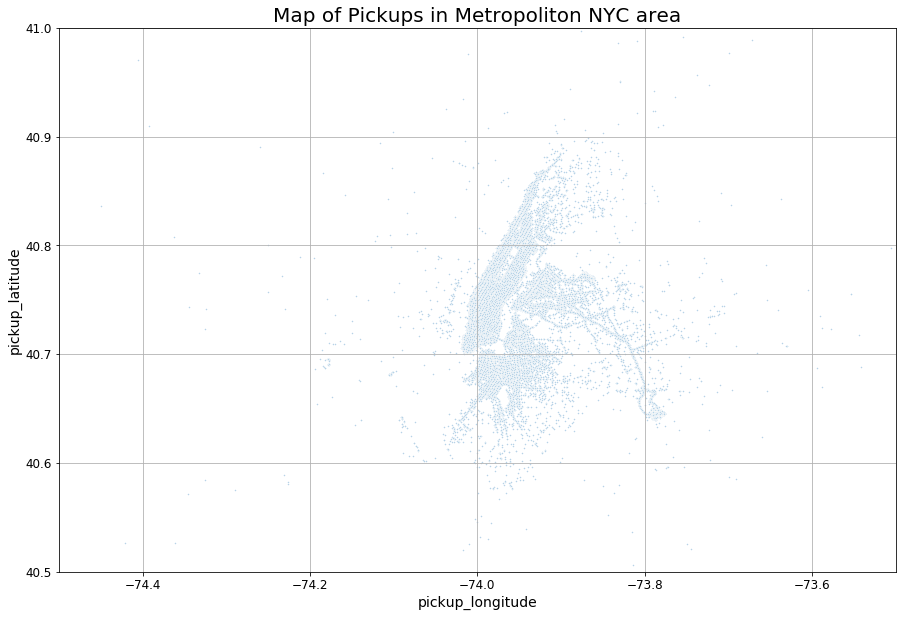

In [29]:
# creating a map of pickups
x=df_train["pickup_longitude"]
y=df_train["pickup_latitude"]
sns.scatterplot(x,y,s=2)

# control x and y limits
plt.ylim(40.5, 41)
plt.xlim(-74.5, -73.5)
# Northeast-most corner of metro NYC: 40.875730, -73.718218
# Southwest-most corner of metro NYC: 40.552268, -74.191209
plt.title('Map of Pickups in Metropoliton NYC area', fontsize=20)
plt.grid()

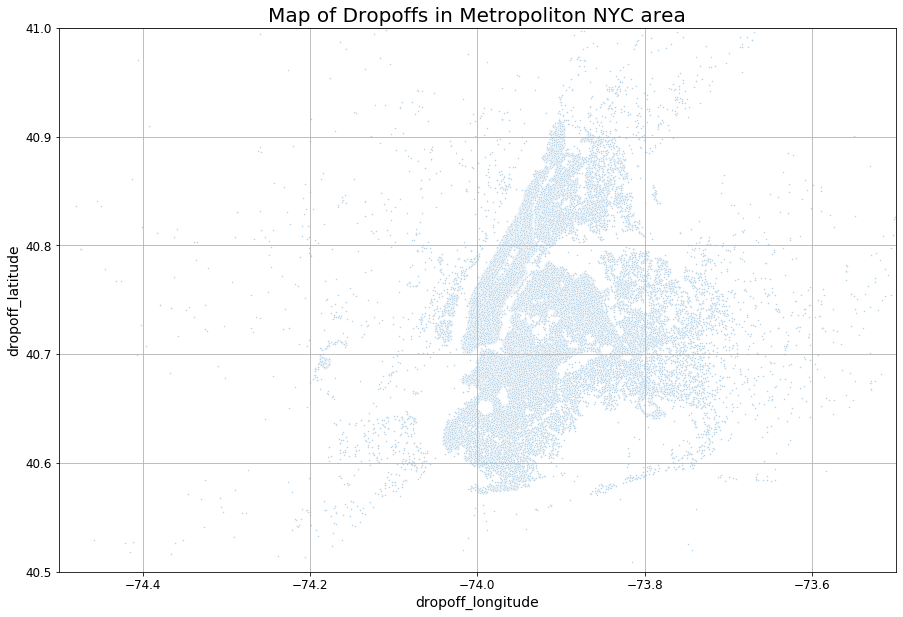

In [30]:
# creating a map of dropoffs
x=df_train["dropoff_longitude"]
y=df_train["dropoff_latitude"]
sns.scatterplot(x,y,s=2)

# control x and y limits
plt.ylim(40.5, 41)
plt.xlim(-74.5, -73.5)
# Northeast-most corner of metro NYC: 40.875730, -73.718218
# Southwest-most corner of metro NYC: 40.552268, -74.191209
plt.title('Map of Dropoffs in Metropoliton NYC area', fontsize=20)
plt.grid()

What we learned: There are definite clear pickup areas, especially around Manhattan and JFK airport. Dropoff is much more dispersed.

In [31]:
df_train.drop(df_train[
                       (df_train.pickup_longitude < -74.5) | (df_train.pickup_longitude > -73.5) |\
                       (df_train.dropoff_longitude < -74.5) | (df_train.dropoff_longitude > -73.5) |\
                       (df_train.pickup_latitude < 40.5) | (df_train.pickup_latitude > 41) |\
                       (df_train.dropoff_latitude < 40.5) | (df_train.dropoff_latitude > 41)
].index, inplace=True)
print("Entries with Latitudes outside 40.5 - 41 degrees North or Longitudes outside -73.5 - -74.5 West removed")

Entries with Latitudes outside 40.5 - 41 degrees North or Longitudes outside -73.5 - -74.5 West removed


# Data Engineering - Training Data
We are going to start extracting and manipulating features in the TRAINING DATA to make them more useful in final processing/calculating

In [32]:
le = LabelEncoder()
le.fit(df_train['store_and_fwd_flag'])
df_train['store_and_fwd_flag'] = le.transform(df_train['store_and_fwd_flag'])
df_test['store_and_fwd_flag'] = le.transform(df_test['store_and_fwd_flag'])
print("store_and_fwd_flag was previously either 'N' or 'Y'. It should now be 0 and 1.")
print("Let's confirm:")
print(f"store_and_fwd_flag has {len(df_train.store_and_fwd_flag.unique())} unique values: {list(df_train.store_and_fwd_flag.unique())}")

store_and_fwd_flag was previously either 'N' or 'Y'. It should now be 0 and 1.
Let's confirm:
store_and_fwd_flag has 2 unique values: [0, 1]


In [33]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['day'] = df_train['pickup_datetime'].dt.day
df_train['dayofweek'] = df_train['pickup_datetime'].dt.dayofweek
df_train['weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['minute'] = df_train['pickup_datetime'].dt.minute
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
print("Time and date data can now be processed and manipulated with pandas")

Time and date data can now be processed and manipulated with pandas


In [34]:
# Just a quick check to confirm datetime data matches trip_duration data
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime'])\
.map(lambda x: x.total_seconds())
print("To confirm datetime feature matches trip_duration feature, we will")
print("subtract pickup_datetime from dropoff_datetime and compare that to trip_duration")
print(f"There are {sum(df_train['check_trip_duration'] != df_train.trip_duration)} line(s) that don't match.")

To confirm datetime feature matches trip_duration feature, we will
subtract pickup_datetime from dropoff_datetime and compare that to trip_duration
There are 0 line(s) that don't match.


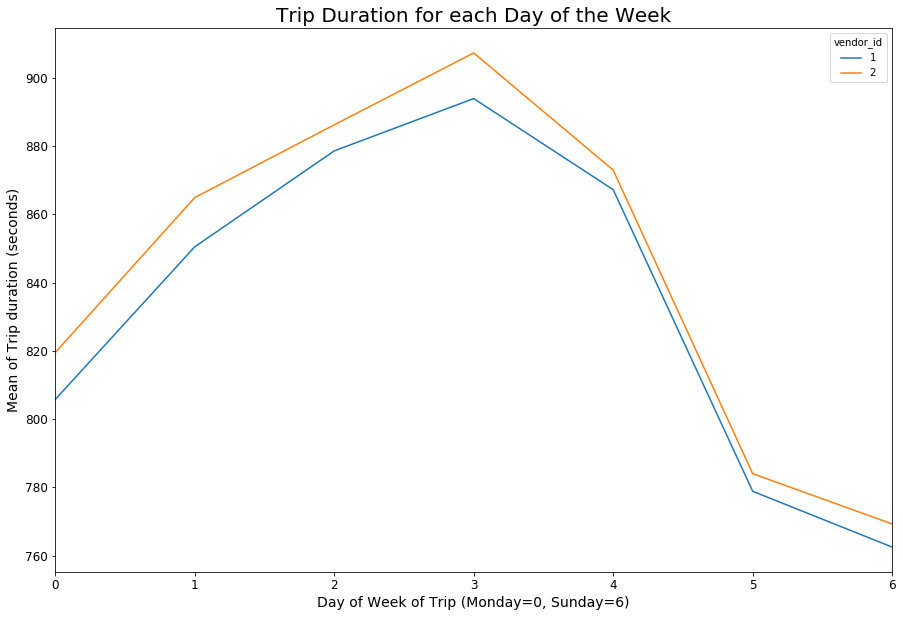

In [35]:
df_train.groupby(['vendor_id','dayofweek'])['trip_duration'].agg("mean").unstack(level=0).plot()
plt.xlabel("Day of Week of Trip (Monday=0, Sunday=6)")
plt.ylabel("Mean of Trip duration (seconds)");
plt.title("Trip Duration for each Day of the Week", fontsize=20)
plt.show()

What we learned:

~~1.   Vendor 2 has a longer average trip duration than Vendor 1~~

~~2.   On average, Vendor 2 has its longest trips on Thursday and Friday~~

`~3.   On average, Vendor 1 has its longest trips on Tuesday and Thursday~~

The above no longer apply now that outlier trip lengths and locations have been removed.

What we actually learned:
1.   2 Vendors are almost identical
2.   Thursday has longest trip duration


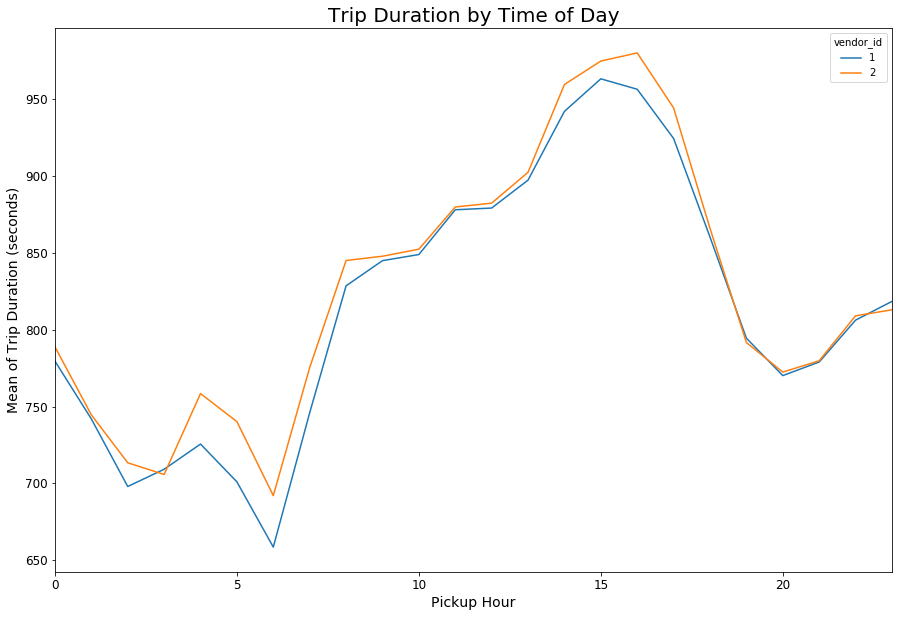

In [36]:
df_train.groupby(['vendor_id','hour'])['trip_duration'].agg("mean").unstack(level=0).plot()
plt.xlabel("Pickup Hour")
plt.ylabel("Mean of Trip Duration (seconds)")
plt.title("Trip Duration by Time of Day", fontsize=20)
plt.show()

What we learned:
1.   Trip duration increases from 6am-3pm for both vendors.

~~2.   Spike in trip duration at 11pm.~~

~~3.   Both vendors follow roughly the same pattern except during early morning hours before 6am, when vendor 2 does much longer trips.~~

2.   By deleting outliers, we now realize both vendors have almost identical trip durations by hour.
3.   Trip duration highest at around 3pm.

In [37]:
df_train['dist_long'] = df_train['pickup_longitude'] - df_train['dropoff_longitude']
df_train['dist_lat'] = df_train['pickup_latitude'] - df_train['dropoff_latitude']
df_train['dist'] = np.sqrt(np.square(df_train['dist_long']) + np.square(df_train['dist_lat']))
print("We've now created a column 'dist' that roughly estimates the distance traveled")

We've now created a column 'dist' that roughly estimates the distance traveled


In [38]:
# spatial features: count and speed
df_train['pickup_longitude_bin'] = np.round(df_train['pickup_longitude'], 2)
df_train['pickup_latitude_bin'] = np.round(df_train['pickup_latitude'], 2)
df_train['dropoff_longitude_bin'] = np.round(df_train['dropoff_longitude'], 2)
df_train['dropoff_latitude_bin'] = np.round(df_train['dropoff_latitude'], 2)
print("We've created these _bin columns in order to group the locations into bins\
 and to simplify upcoming manipulations to calculate speed.")

We've created these _bin columns in order to group the locations into bins and to simplify upcoming manipulations to calculate speed.


# Data Engineering - Test Data
We are going to start extracting and manipulating features in the TEST DATA to make them more useful in final processing/calculating

In [39]:
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test['month'] = df_test['pickup_datetime'].dt.month
df_test['day'] = df_test['pickup_datetime'].dt.day
df_test['dayofweek'] = df_test['pickup_datetime'].dt.dayofweek
df_test['weekday'] = df_test['pickup_datetime'].dt.weekday
df_test['hour'] = df_test['pickup_datetime'].dt.hour
df_test['minute'] = df_test['pickup_datetime'].dt.minute
df_test['dist_long'] = df_test['pickup_longitude'] - df_test['dropoff_longitude']
df_test['dist_lat'] = df_test['pickup_latitude'] - df_test['dropoff_latitude']
df_test['dist'] = np.sqrt(np.square(df_test['dist_long']) + np.square(df_test['dist_lat']))
df_test['pickup_longitude_bin'] = np.round(df_test['pickup_longitude'], 2)
df_test['pickup_latitude_bin'] = np.round(df_test['pickup_latitude'], 2)
df_test['dropoff_longitude_bin'] = np.round(df_test['dropoff_longitude'], 2)
df_test['dropoff_latitude_bin'] = np.round(df_test['dropoff_latitude'], 2)
print('And now the data engineering is repeated for the test data')

And now the data engineering is repeated for the test data


In [0]:
## count features
a = pd.concat([df_train,df_test]).groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).size().reset_index()
b = pd.concat([df_train,df_test]).groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).size().reset_index()

df_train = pd.merge(df_train, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')
df_test = pd.merge(df_test, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')

df_train = pd.merge(df_train, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')
df_test = pd.merge(df_test, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')

## speed features
df_train['speed'] = 100000*df_train['dist'] / df_train['trip_duration']

a = df_train[['speed', 'pickup_longitude_bin', 'pickup_latitude_bin']].groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).mean().reset_index()
a = a.rename(columns = {'speed': 'ave_speed'})
b = df_train[['speed', 'dropoff_longitude_bin', 'dropoff_latitude_bin']].groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).mean().reset_index()
b = b.rename(columns = {'speed': 'ave_speed'})

df_train = pd.merge(df_train, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')
df_test = pd.merge(df_test, a, on = ['pickup_longitude_bin', 'pickup_latitude_bin'], how = 'left')

df_train = pd.merge(df_train, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')
df_test = pd.merge(df_test, b, on = ['dropoff_longitude_bin', 'dropoff_latitude_bin'], how = 'left')

## drop bins
df_train = df_train.drop(['check_trip_duration', 'speed', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'], axis = 1)
df_test = df_test.drop(['pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'], axis = 1)

A couple columns relating to speed have now been added. This speed, of course, is an extremely rough value based on the extremely rough estimate of distance derived by pickup and dropoff coordinates. 

In a future iteration, the goal of this would be to figure out how to integrate the more accurate 'fastest_route' data from the OSMR dataset found [here](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm). 

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448247 entries, 0 to 1448246
Data columns (total 25 columns):
id                    1448247 non-null object
vendor_id             1448247 non-null int64
pickup_datetime       1448247 non-null datetime64[ns]
dropoff_datetime      1448247 non-null datetime64[ns]
passenger_count       1448247 non-null int64
pickup_longitude      1448247 non-null float64
pickup_latitude       1448247 non-null float64
dropoff_longitude     1448247 non-null float64
dropoff_latitude      1448247 non-null float64
store_and_fwd_flag    1448247 non-null int64
trip_duration         1448247 non-null int64
log_trip_duration     1448247 non-null float64
month                 1448247 non-null int64
day                   1448247 non-null int64
dayofweek             1448247 non-null int64
weekday               1448247 non-null int64
hour                  1448247 non-null int64
minute                1448247 non-null int64
dist_long             1448247 non-null float64
d

# Combining our Taxi trip data with the weather data
Logically speaking, one of the biggest influences on trip-time would be the weather. Snow, flooding, heavy rain, etc, would all significantly increase travel time. 

In future iterations of this notebook, we would hope to integrate more of the features from the knycmetars2016 dataset into our training/test data. Unfortunately, at this time, only temperature has been considered.

In [42]:
#### weather data
weather = pd.read_csv('KNYC_Metars.csv')
weather['Time'] = pd.to_datetime(weather['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hour'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016]

df_train = pd.merge(df_train, weather[['Temp.', 'month', 'day', 'hour']], on = ['month', 'day', 'hour'], how = 'left')
df_test = pd.merge(df_test, weather[['Temp.', 'month', 'day', 'hour']], on = ['month', 'day', 'hour'], how = 'left')

print("The specific weather conditions in 2016 have now been broken out based on time\
 and appended to the training and test datasets.")

The specific weather conditions in 2016 have now been broken out based on time and appended to the training and test datasets.


In [43]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,month,day,dayofweek,weekday,hour,minute,dist_long,dist_lat,dist,0_x,0_y,ave_speed_x,ave_speed_y,Temp.
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,6.120297,3,14,0,0,17,24,-0.017525,0.002335,0.017680,68026,72529,3.613149,3.899837,4.4
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6.496775,6,12,6,6,0,43,0.019066,0.007412,0.020456,59250,51679,3.859893,3.553449,28.9
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,7.661056,1,19,1,1,11,35,0.026306,0.053852,0.059934,110772,37919,3.467936,4.331951,-6.7
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6.061457,4,6,2,2,19,32,0.002228,0.013252,0.013438,29881,37919,4.035004,4.331951,7.2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,6.075346,3,26,5,5,13,30,-0.000130,0.010689,0.010690,36268,11359,4.412874,4.064792,9.4


In [44]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,month,day,dayofweek,weekday,hour,minute,dist_long,dist_lat,dist,0_x,0_y,ave_speed_x,ave_speed_y,Temp.
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,6,30,3,3,23,59,0.002045,-0.024651,0.024735,72999,74901,3.703671,3.346367,24.4
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,6,30,3,3,23,59,-0.004395,0.024590,0.024979,468,1015,4.651619,5.401221,24.4
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,6,30,3,3,23,59,-0.011276,0.008060,0.013861,62502,58168,3.771366,3.562101,24.4
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,6,30,3,3,23,59,0.030357,0.041431,0.051363,73410,58168,3.895919,3.562101,24.4
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,6,30,3,3,23,59,-0.008705,0.005585,0.010343,128271,35889,3.844647,3.800646,24.4


In [45]:
print(f"shape of training set{df_train.shape}")
print(f"shape of testing set{df_test.shape}")


shape of training set(1448247, 26)
shape of testing set(625134, 23)


Hopefully, the data has been cleaned and engineered sufficiently to provide reliable training data for our machine learning algorithm below.

# Time to start calculating!

In [46]:
col_diff = list(set(df_train.columns).difference(set(df_test.columns)))
print(f"The difference between the Training and Testing Datasets:\
{set(df_train.columns).difference(set(df_test.columns))}")


The difference between the Training and Testing Datasets:{'log_trip_duration', 'dropoff_datetime', 'trip_duration'}


In [47]:
xtrain = df_train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'log_trip_duration'], axis = 1).as_matrix()
xtest = df_test.drop(['id', 'pickup_datetime', ], axis = 1).as_matrix()
y = df_train['log_trip_duration'].values
del(df_train, df_test)
print("df_train and df_test deleted.")
print("xtrain, xtest, and y created.")

df_train and df_test deleted.
xtrain, xtest, and y created.


Here, our first step was to modify the test and training datasets by 
dropping the trip IDs as well as the pickup/dropoff datetime info, which will be in the separate dataset Y, that has our normally distributed 'log_trip_duration' feature. 

They were then saved as the matrices xtrain and xtest.

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain,y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1158597, 21), (289650, 21), (1158597,), (289650,))

First random split complete.

In [49]:
# This is for calculating the RMSLE score that this competition uses
def rmse(y,pred):
    return np.sqrt(np.mean(np.square(np.log(np.exp(y))-np.log(np.exp(pred)))))
print('Root Mean Square Log Error score defined.')

Root Mean Square Log Error score defined.


This Kaggle competition uses RMSLE to compute the final score for the notebook. This is a regression evaluation metric that essentially is the usual RMSE, but gets the log of the values first. Equation below:
![RMSLE equation](https://miro.medium.com/max/1865/0*AUzyQ1rc6mpQVYfn)
This equation is often used because:
1.   It's more 'robust' to the effects of outliers
2.   By getting the log of the actual values, the RMSLE will not increase proportional to the magnitude of the actual values themselves. That means that the RMSLE score is comparable between various competitions, even if the scale of the values involved are vastly different.

### Now we start to use LightGBM to start predicting trip duration
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

*   Faster training speed and higher efficiency.
*   Lower memory usage.
*   Better accuracy.
*   Support of parallel and GPU learning.
*   Capable of handling large-scale data.



In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)
# training all dataset
dtrain = lgb.Dataset(xtrain,y)
del(X_train, y_train, X_valid, y_valid, xtrain,y)

Here, all the data is put into lgb datsets that the machine learning algorithm can read/manipulate.

In [51]:
lgb_params = {
    'learning_rate': 0.1,
    'max_depth': 8,
    'num_leaves': 55, 
    'objective': 'regression',
    'metric': {'rmse'},
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'max_bin': 300}
print("Parameters for LightGBM algorithm is set here")

Parameters for LightGBM algorithm is set here


In [52]:
cv_result_lgb = lgb.cv(lgb_params,
                       dtrain, 
                       num_boost_round=1000, 
                       nfold=3,
                       early_stopping_rounds=50, 
                       verbose_eval=100, 
                       show_stdv=True,stratified=False)

[100]	cv_agg's rmse: 0.329442 + 0.000585156
[200]	cv_agg's rmse: 0.320427 + 0.000522429
[300]	cv_agg's rmse: 0.316655 + 0.000441796
[400]	cv_agg's rmse: 0.314573 + 0.000650655
[500]	cv_agg's rmse: 0.312975 + 0.0004822
[600]	cv_agg's rmse: 0.311855 + 0.000447177
[700]	cv_agg's rmse: 0.310864 + 0.000544942
[800]	cv_agg's rmse: 0.31028 + 0.000498137
[900]	cv_agg's rmse: 0.309495 + 0.0004863
[1000]	cv_agg's rmse: 0.308901 + 0.000559253


RMSLE score of 0.308901 seems a little too good to be true. If there is an error, our suspicion is that it is in either 

1.   In the step two above this where the parameters for the lgbm algorithm is set. Specifically, the row where the 'metric' is specified.

2.   In the step several boxes above, entitled: # This is for calculating the RMSLE score that this competition uses. 


In [0]:
model_lgb = lgb.train(lgb_params, 
                      dtrain,
                      num_boost_round=1500)


Using the LightGBM algorithm parameters set 2 steps ago and the dtrain dataset, we will train the model (model_lgb) that will eventually be used to calculate our submission.

### Submitting to kaggle
Kaggle submissions have to be in the same format as the sample_submission.csv document. It entails replacing the '959' value in the trip duration in all rows with the predicted trip_duration for the trip ids given.

In [54]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [55]:
pred_test = np.exp(model_lgb.predict(xtest))
submit['trip_duration'] = pred_test
print("Predicted trip_duration added to sample_submission dataframe")

Predicted trip_duration added to sample_submission dataframe


In [56]:
submit.head()

,id,trip_duration
0,id3004672,840.202344
1,id3505355,646.273979
2,id1217141,417.789721
3,id2150126,952.278636
4,id1598245,353.779058


In [57]:
submit.to_csv("submit_file.csv", index=False)
print("Predicted trip_duration added to sample_file.csv")

Predicted trip_duration added to sample_file.csv


# Conclusion

Assuming our RMSLE calculations were done correctly, our final score through the end of the notebook was ~0.309. 

Further data engineering can be done by:
1.   Using fastest route data using the OSMR data, instead of estimates based on coordinates
2.   Adding further weather information, including snow and rain, not just temperature
3.   Creating categories based on general starting point, such as borough or airport

### References:
This notebook was mostly adapted from the code found at:
[This Kaggle Notebook](https://www.kaggle.com/baoanh/nyc-taxi-trip-duration-by-nguyen-khac-bao-anh/notebook)